In [67]:
# !pip install pandas
# !pip install scikit-learn 
# !pip install matplotlib

In [68]:
import pandas as pd
df = pd.read_csv('Monthly_Gold_Price_on_World.csv', usecols=['Date', 'Indonesian rupiah (IDR)'])
df

,Date,Indonesian rupiah (IDR)
0,1979-01-31,139739.28
1,1979-02-28,154683.13
2,1979-03-30,148844.15
3,1979-04-30,152453.63
4,1979-05-31,171656.12
...,...,...
513,2021-10-29,25064431.24
514,2021-11-30,25843517.60
515,2021-12-31,25737878.52
516,2022-01-31,25819285.50


In [69]:
import joblib

data = df['Indonesian rupiah (IDR)']
n = len(data)
sizeTrain = (round(n*0.8))
data_train = pd.DataFrame(data[:sizeTrain])
data_test = pd.DataFrame(data[sizeTrain:])

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(data_train)

# Mengaplikasikan MinMaxScaler pada data pengujian
test_scaled = scaler.transform(data_test)
joblib.dump(scaler, 'modelScaler.pkl')

train = pd.DataFrame(train_scaled, columns = ['data'])
train = train['data']

test = pd.DataFrame(test_scaled, columns = ['data'])
test = test['data']
test

0      0.793164
1      0.895255
2      0.902979
3      0.877109
4      0.880918
         ...   
99     1.478633
100    1.524851
101    1.518584
102    1.523414
103    1.619491
Name: data, Length: 104, dtype: float64

In [70]:
import numpy as np
from numpy import array

def split_sequence(sequence, n_steps):
  X, y = list(), list()
  for i in range(len(sequence)):
    # find the end of this pattern
    end_ix = i + n_steps
    # check if we are beyond the sequence
    if end_ix > len(sequence)-1:
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
    X.append(seq_x)
    y.append(seq_y)

  return array(X), array(y)

df_X, df_Y = split_sequence(train, 2)
x = pd.DataFrame(df_X)
y = pd.DataFrame(df_Y)
dataset_train = pd.concat([x, y], axis=1)
dataset_train

X_train = dataset_train.iloc[:, :2].values
Y_train = dataset_train.iloc[:, -1].values
test_x, test_y = split_sequence(test, 2)
x = pd.DataFrame(test_x)
y = pd.DataFrame(test_y)
dataset_test = pd.concat([x, y], axis=1)
dataset_test.to_csv('data-test.csv', index=False)
X_test = dataset_test.iloc[:, :2].values
Y_test = dataset_test.iloc[:, -1].values

In [71]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error

models = []
errors = []

model = LinearRegression()
model.fit(X_train, Y_train)

y_pred=model.predict(X_test)
error = mean_absolute_percentage_error(y_pred, Y_test)
models.append(model)
errors.append(error)
print('Linear = ',error)

model = DecisionTreeRegressor()
model.fit(X_train, Y_train)

y_pred=model.predict(X_test)
error = mean_absolute_percentage_error(y_pred, Y_test)
models.append(model)
errors.append(error)

print('Decision Tree = ',error)
indexModel = np.argmin(errors)
joblib.dump(models[indexModel], 'modelLR.pkl')
lr = models[indexModel]

Linear =  0.02931332599692603
Decision Tree =  0.23178444642210036


In [72]:
def ramal(n_pred, dataset_test, tanggal):
    tanggal = tanggal[0].split('-')
    tahun = tanggal[0]
    bulan = tanggal[1]
    tahun = int(tahun)
    bulan = int(bulan)
    # lr = LinearRegression()
    last = dataset_test.tail(1)
    fitur = last.values
    n_fit = len(fitur[0])
    fiturs = np.zeros((n_pred, n_fit))
    tanggals = []
    preds = np.zeros(n_pred)
    for i in range(n_pred):
        if i == 0:
            fitur = fitur[:, 1:n_fit]
            y_pred=lr.predict(fitur)
            new_fit = np.array(fitur[0])
            new_fit = np.append(new_fit,y_pred)
        else:
            fitur = fiturs[i-1][1:n_fit]
            y_pred=lr.predict([fitur])
            new_fit = np.array(fitur)
            new_fit = np.append(new_fit,y_pred)
        preds[i] = y_pred
        fiturs[i,:] = new_fit
        bulan += 1
        if bulan > 12:
          tahun += 1
          bulan = 1
        tanggal = str(tahun)+"-"+f"{bulan:02d}"
        tanggals.append(tanggal)
    return preds, tanggals

tanggal_terakhir = df['Date'].tail(1).values
pred, tanggal = ramal(3,dataset_test, tanggal_terakhir)
reshaped_data = pred.reshape(-1, 1)
original_data = scaler.inverse_transform(reshaped_data)
pred = original_data.flatten()
# df_pred['Indonesian rupiah (IDR)'] = df_pred['Indonesian rupiah (IDR)']
df_pred = pd.DataFrame({'Date': tanggal, 'Indonesian rupiah (IDR)': format(pred, '.2f') })
df_pred

AttributeError: 'numpy.ndarray' object has no attribute 'apply'

In [ ]:
from datetime import datetime

def moddate(tanggal_awal):
    if isinstance(tanggal_awal, pd.Timestamp):
        # Convert Timestamp object to string
        tanggal_str = tanggal_awal.strftime('%Y-%m-%d')

        # Ubah string tanggal menjadi objek datetime
        tanggal_obj = datetime.strptime(tanggal_str, '%Y-%m-%d')
    else:
        # Ubah string tanggal menjadi objek datetime
        tanggal_obj = datetime.strptime(tanggal_awal, '%Y-%m-%d')


    # Memformat tanggal menjadi 'YYYY-MM'
    return tanggal_obj.strftime('%Y-%m')


df['Date'] = df['Date'].apply(moddate)
df['Date']

0      1979-01
1      1979-02
2      1979-03
3      1979-04
4      1979-05
        ...   
513    2021-10
514    2021-11
515    2021-12
516    2022-01
517    2022-02
Name: Date, Length: 518, dtype: object

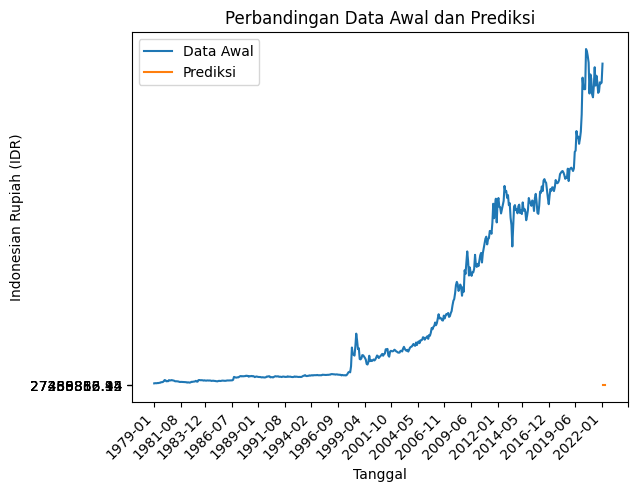

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Plot data df
plt.plot(df['Date'], df['Indonesian rupiah (IDR)'], label='Data Awal')

# Plot data df_pred
plt.plot(df_pred['Date'], df_pred['Indonesian rupiah (IDR)'], label='Prediksi')

# Menghubungkan plot terakhir data awal dengan plot awal data prediksi
last_Date = df['Date'].iloc[-1]
plt.plot([last_Date, df_pred['Date'].iloc[0]], [df['Indonesian rupiah (IDR)'].iloc[-1], df_pred['Indonesian rupiah (IDR)'].iloc[0]], 'k--')

# Konfigurasi plot
plt.xlabel('Tanggal')
plt.ylabel('Indonesian Rupiah (IDR)')
plt.title('Perbandingan Data Awal dan Prediksi')
plt.legend()

# Atur jarak pada nilai label sumbu x dan format tanggal
plt.xticks(rotation=45, ha='right')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

# Tampilkan plot
plt.show()